In [49]:
import numpy as np
from random import choice, random
import matplotlib.pyplot as plt
from typing import Tuple
from tqdm import tqdm
import matplotlib.patches as mpatches
import matplotlib.animation as animation
import matplotlib as mpl

In [50]:
# set serif as default font in matplotlib
import matplotlib as mpl
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "lines.linewidth": 1.5,
    "figure.dpi": 200,
    "axes.grid": True,
    "grid.color": "#cccccc",
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.edgecolor": "0.2",
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
})


In [51]:
class PageHinkley:
    def __init__(self, delta=0.01, threshold=300.0):
        """
        Parámetros:
          - delta: un pequeño valor (bias) que evita detectar cambios por fluctuaciones menores.
          - threshold: umbral que, al ser superado, indica que se ha detectado un cambio.
        """
        self.delta = delta
        self.threshold = threshold
        self.reset()

    def reset(self):
        """Reinicia los acumulados y contadores del test."""
        self.mean = 0.0
        self.cumulative_sum = 0.0
        self.min_cumulative_sum = 0.0
        self.n = 0

    def update(self, x):
        """
        Actualiza el PH-Test con el valor x (en este caso, la recompensa acumulada del episodio)
        y retorna True si se detecta un cambio.
        """
        self.n += 1
        # Actualización incremental de la media
        self.mean = self.mean + (x - self.mean) / self.n
        # Se acumula la diferencia entre el valor actual, la media y el delta
        self.cumulative_sum += (self.mean - x - self.delta)
        # Se guarda el mínimo acumulado
        self.min_cumulative_sum = min(self.min_cumulative_sum, self.cumulative_sum)
        # Si la diferencia acumulada (desde el mínimo) supera el umbral, se detecta un cambio
        
        #print(f"n: {self.n}, x: {x}, mean: {self.mean}, cum_sum: {self.cumulative_sum}, min_cum_sum: {self.min_cumulative_sum}")
        if (self.cumulative_sum - self.min_cumulative_sum) > self.threshold:
            return True
        else:
            return False


In [52]:
class AdaptativeAgent():
    def __init__(
        self,
        initial_state: Tuple[int, int],
        actions: list,
        n_rows: int,
        n_cols: int,
        alpha: float = 0.1,    # Tasa de aprendizaje base
        gamma: float = 0.9,    # Factor de descuento
        min_epsilon: float = 0.1,
        decay_rate: float = 0.003,
        alpha_max: float = 0.99,  # Tasa de aprendizaje máxima en caso de gran error
        td_threshold: float = 0.1,  # Umbral para activar adaptación
    ):
        # Parámetros de Q-learning
        self.alpha = alpha              # Tasa base
        self.gamma = gamma
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.alpha_max = alpha_max
        self.td_threshold = td_threshold
        self.effective_alpha = alpha
        
        # Configuración del entorno
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.actions = actions
        
        # Estado inicial
        self.initial_state = initial_state
        self.current_state = initial_state
        
        # Q-table (diccionario de diccionarios)
        self.q_knowledge = np.zeros((len(self.actions), self.n_rows, self.n_cols))
        # (Opcional) Puedes mantener o ampliar la memoria a corto plazo si deseas más análisis
        #self.short_term_memory = {}
        
        # Contadores
        self.steps = 0
        
        # Aux
        self.map_ix_action = {i: a for i, a in enumerate(self.actions)}  
        self.map_action_ix = {a: i for i, a in enumerate(self.actions)}      
    
    def get_next_state(self, base_state: Tuple[int, int], action: str) -> Tuple[int, int]:
        """Calcula el próximo estado según la acción"""
        row, col = base_state
        
        if action == 'Up':
            return (max(row-1, 0), col)
        if action == 'Down':
            return (min(row+1, self.n_rows-1), col)
        if action == 'Left':
            return (row, max(col-1, 0))
        if action == 'Right':
            return (row, min(col+1, self.n_cols-1))
        return base_state  # Caso por defecto
    
    def get_best_action(self, state: Tuple[int, int]) -> Tuple[str, float]:
        """Selecciona la mejor acción usando explotación"""
        action = np.argmax(self.q_knowledge[:, state[0], state[1]])
        action = self.map_ix_action[action]
        q_value = np.max(self.q_knowledge[:, state[0], state[1]])
        return action, q_value
    
    def update_q_value(
        self,
        current_state: Tuple[int, int],
        action: str,
        reward: float,
        next_state: Tuple[int, int]
    ) -> float:
        """
        Actualiza la Q-table usando una tasa de aprendizaje adaptativa que 
        fusiona el conocimiento previo con la nueva información.
        """
        action = self.map_action_ix[action]
        current_q = self.q_knowledge[action][current_state]
        # Obtener la mejor acción en el siguiente estado
        _, next_max_q = self.get_best_action(next_state)
        
        # Calcular el TD error
        td_error = reward + self.gamma * next_max_q - current_q
        
        # Función sigmoide para ajustar la tasa de aprendizaje:
        activation = 1.0 / (1.0 + np.exp(-(abs(td_error) - self.td_threshold)))
        effective_alpha = self.alpha + (self.alpha_max - self.alpha) * activation
        
        # Actualizar la Q-table de forma "fuzzy":
        self.effective_alpha = effective_alpha
        new_q = current_q + self.effective_alpha * td_error            
        
        self.q_knowledge[action][current_state] = new_q
        
        
        return new_q
    
    def choose_action(self, epsilon: float) -> str:
        """Selección de acción epsilon-greedy"""
        if random() < epsilon:
            # Exploración: filtrar solo acciones que cambien el estado
            valid_actions = [
                a for a in self.actions
                if self.get_next_state(self.current_state, a) != self.current_state
            ]
            if valid_actions:
                return choice(valid_actions)
            else:
                return choice(self.actions)
        # Explotación
        best_action, _ = self.get_best_action(self.current_state)
        return best_action
    
    def epsilon_decay(self, step: int) -> float:
        """Decaimiento exponencial de epsilon"""
        return self.min_epsilon + (1 - self.min_epsilon) * np.exp(-self.decay_rate * step)
    
    def move(self, reward: float, action, next_state) -> float:
        """
        Realiza un paso completo de Q-learning:
            1. Actualiza la Q-table usando la tasa de aprendizaje adaptativa.
            2. Cambia al nuevo estado.
        """
        #next_state = self.get_next_state(self.current_state, action)
        
        new_q = self.update_q_value(
            current_state=self.current_state,
            action=action,
            reward=reward,
            next_state=next_state
        )
        
        # Actualizar el estado y el contador de pasos
        self.current_state = next_state
        self.steps += 1
                
        return new_q
    
    def restart(self) -> None:
        """Reinicia el agente a su estado inicial sin borrar la Q-table (se conserva el conocimiento)"""
        self.current_state = self.initial_state
        self.steps = 0
        
    def __str__(self) -> str:
        return f"AdaptativeAgent at {self.current_state} with Q-values {self.q_knowledge[self.current_state]}"


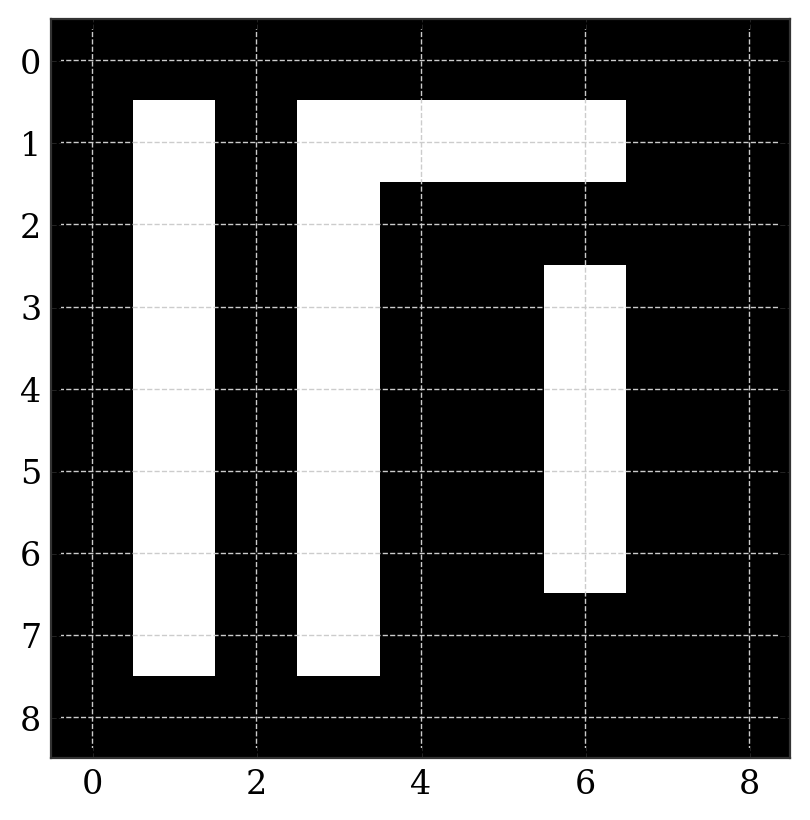

In [79]:
GRID_WORLD = np.array(
      [[ -1.,  -1,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
       [ -1.,    np.nan,  -1.,     np.nan, np.nan, np.nan,  np.nan,  -1.,  -1.],
       [ -1.,    np.nan, -1.,      np.nan, -1, -1,  -1,  -1.,  -1.],
       [ -1 ,    np.nan, -1.,      np.nan, -1, -1., np.nan,  -1.,  -1.],
       [ -1.,    np.nan,  -1.,     np.nan, -1, -1., np.nan,  -1.,  -1.],
       [ -1.,    np.nan,  -1.,     np.nan, -1, -1., np.nan,  -1.,  -1.],
       [ -1.,    np.nan,  -1.,     np.nan, -1, -1., np.nan,  -1.,  -1.],
       [ -1.,    np.nan,  -1, np.nan,  -1,  -1.,  -1.,  -1.,  -1.],
       [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.]]
)

plt.imshow(GRID_WORLD, cmap='gray', interpolation='nearest')

Converged at episode 235:
Converged at episode 301:
Converged at episode 604:
Converged at episode 901:
Converged at episode 1202:
Entrenamiento finalizado.


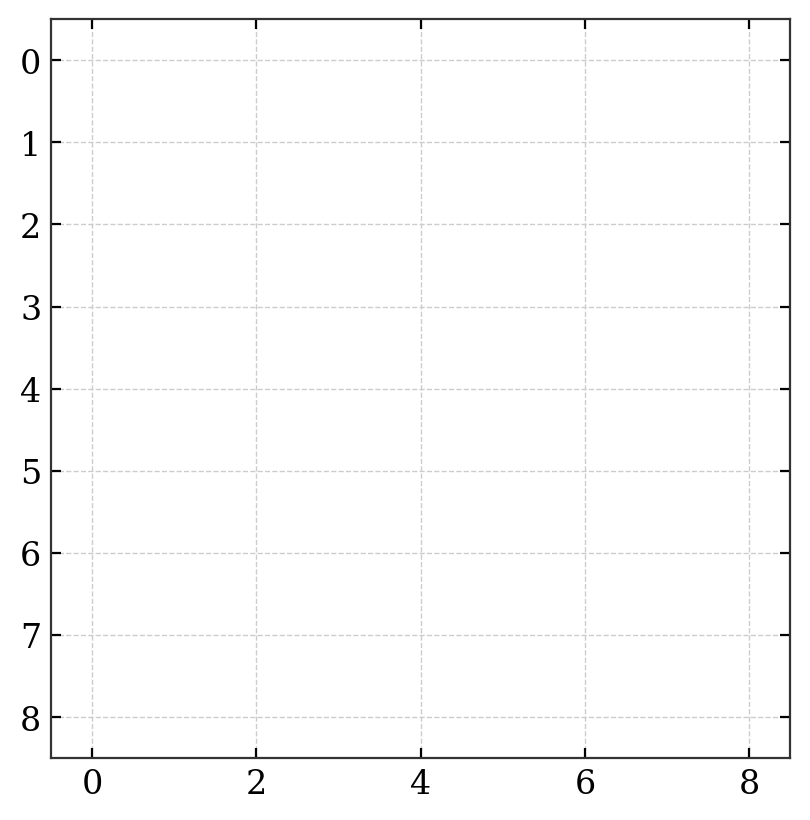

In [ ]:
# Inicialización del entorno y parámetros
N_ROWS = 9
N_COLS = 9
#GRID_WORLD = np.zeros((N_ROWS, N_COLS)) - 1

GRID_WORLD = np.array(
      [[ -1.,  -1,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
       [ -1.,    np.nan,  -1.,     np.nan, np.nan, np.nan,  np.nan,  -1.,  -1.],
       [ -1.,    np.nan, -1.,      np.nan, -1, -1,  -1,  -1.,  -1.],
       [ -1 ,    np.nan, -1.,      np.nan, -1, -1., np.nan,  -1.,  -1.],
       [ -1.,    np.nan,  -1.,     np.nan, -1, -1., np.nan,  -1.,  -1.],
       [ -1.,    np.nan,  -1.,     np.nan, -1, -1., np.nan,  -1.,  -1.],
       [ -1.,    np.nan,  -1.,     np.nan, -1, -1., np.nan,  -1.,  -1.],
       [ -1.,    np.nan,  -1, np.nan,  -1,  -1.,  -1.,  -1.,  -1.],
       [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.]]
)

# Definición de los estados meta
GOAL_STATE_1 = (0, 0)
GOAL_STATE_2 = (8, 8)
GRID_WORLD[GOAL_STATE_1] = 100  # Objetivo inicial
GRID_WORLD[GOAL_STATE_2] = -1  # Penalización inicial

EXPLOTATION = 0.2

# Inicialización del agente
agent = AdaptativeAgent(
    initial_state=(4, 5),
    actions=['Up', 'Down', 'Left', 'Right'],
    n_rows=N_ROWS,
    n_cols=N_COLS,
    decay_rate=0.01,
    alpha=0.1,
    alpha_max=0.99,
    td_threshold=5,
)

# Inicialización del Page-Hinkley Test
ph_test = PageHinkley(delta=0.5, threshold=300.0)

# Variables para el seguimiento del entrenamiento
learning_curve = []
exploration_curve = []
step_changes = []
episode_to_step = {}
alpha_evol = []
episode = 0
ite = 0  # Contador total de iteraciones
e = 0     # Contador para la función de decaimiento de epsilon

first_qtable = agent.q_knowledge.copy()
stage_block = [0, 300, 600, 900, 1200 ,1500, 1600]
converged_episodes = []
converged_i = 0

# Variable para la recompensa acumulada del episodio
episode_reward = 0.0

# Para este ejemplo, modificaremos el entorno en episodios específicos
episode_changes = [300, 600, 900, 1200]

q_learning_acc = 0.0

ims = []
fig, ax = plt.subplots()

outlier_reward = None

# Bucle de entrenamiento
while episode < 1500:
    # Selecciona la acción usando epsilon adaptativo
    adaptive_epsilon = agent.epsilon_decay(step=e)
    action = agent.choose_action(adaptive_epsilon)
    
    initial_state = agent.current_state
    next_state = agent.get_next_state(initial_state, action)
    # Si el siguiente estado es inválido (np.nan en el grid), no muevas al agente y asigna una recompensa muy negativa
    if np.isnan(GRID_WORLD[next_state]):
        # Penalización fuerte por intentar moverse a un estado inválido
        reward = -1
        next_state = initial_state
    else:
        reward = GRID_WORLD[next_state]
    
    #reward = GRID_WORLD[next_state]
    
    # Acumula la recompensa del episodio
    episode_reward += reward

    # Realiza el movimiento y actualiza la Q-table
    new_q = agent.move(reward, action, next_state)
    q_learning_acc += new_q

    # Actualiza métricas (por ejemplo, para visualización)
    exploration_curve.append([adaptive_epsilon, new_q])
    alpha_evol.append(agent.effective_alpha)
    
    ite += 1

    # Finaliza el episodio si se alcanza un objetivo o se excede un límite de pasos
    if (GRID_WORLD[next_state]==100) or (agent.steps > (N_COLS + N_ROWS) * 3):
        
        e += 1
        
        if outlier_reward and outlier_reward-episode_reward >= outlier_reward:
            e *= 0.6
        elif outlier_reward and outlier_reward-episode_reward < outlier_reward:
            e *= 15

        episode += 1
        
        # Registra la recompensa media del episodio (puedes ajustar la métrica que prefieras)
        learning_curve.append(q_learning_acc / ite)
        
        if ph_test.update(episode_reward):
            outlier_reward = episode_reward
            print(f"Cambio detectado en episodio {episode} con recompensa {episode_reward}")
            e = 0
            ph_test.reset()
        
        if episode in episode_changes:
            pass

        # Identify if the agent already converged
        if episode > 1:
            # Use stage_block to determine current stage boundaries
            if converged_i < len(stage_block) - 1:
                prev_change = stage_block[converged_i]
                next_change = stage_block[converged_i + 1]
            else:
                prev_change = stage_block[-2]
                next_change = stage_block[-1]
            # Check if Q-table has converged before the next environment change
            if (np.max(np.abs(agent.q_knowledge - first_qtable)) < 0.01) and (prev_change < episode < next_change):
                converged_episodes.append(episode)
                converged_i += 1
                print(f"Converged at episode {episode}:")
            else:
                first_qtable = agent.q_knowledge.copy()
        
        # Reinicia el agente y la recompensa acumulada para el siguiente episodio
        agent.restart()
        episode_reward = 0.0
    
    # (Opcional) Visualización periódica de la Q-table
    if ite % 100 == 0:
        im = ax.imshow(np.max(agent.q_knowledge, axis=0), animated=True)
        color_goal_1 = 'green' if GRID_WORLD[GOAL_STATE_1] == 100 else 'red'
        color_goal_2 = 'red' if color_goal_1 == 'green' else 'green'
        scatter_goal_1 = ax.scatter(GOAL_STATE_1[1], GOAL_STATE_1[0], color=color_goal_1, s=100, animated=True)
        scatter_goal_2 = ax.scatter(GOAL_STATE_2[1], GOAL_STATE_2[0], color=color_goal_2, s=100, animated=True)
        ims.append([im, scatter_goal_1, scatter_goal_2])
        
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
            


print("Entrenamiento finalizado.")

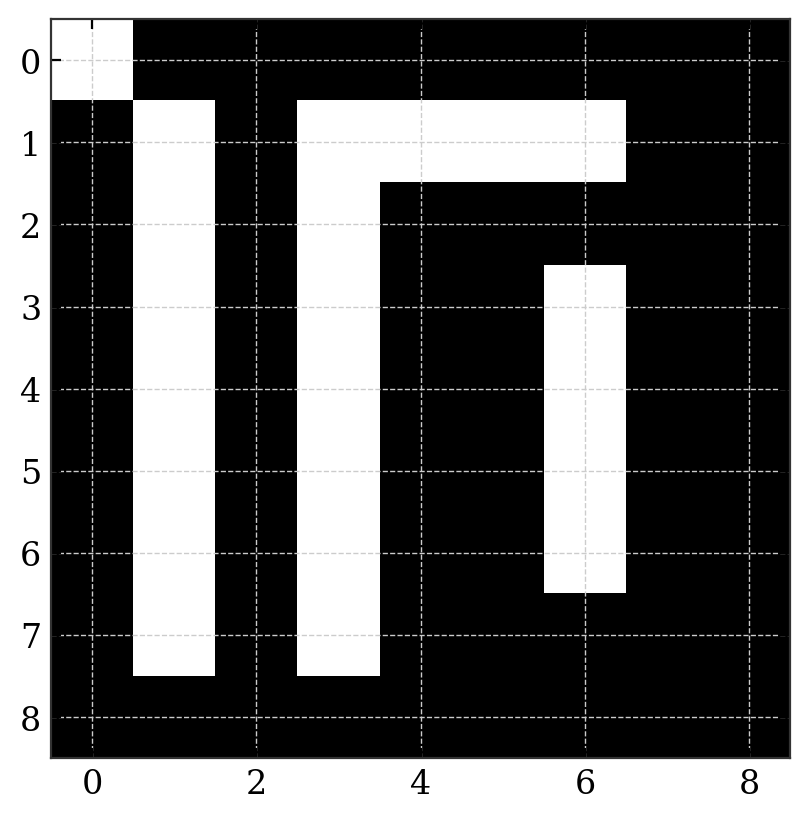

In [81]:
plt.imshow(GRID_WORLD, cmap='gray', interpolation='nearest')

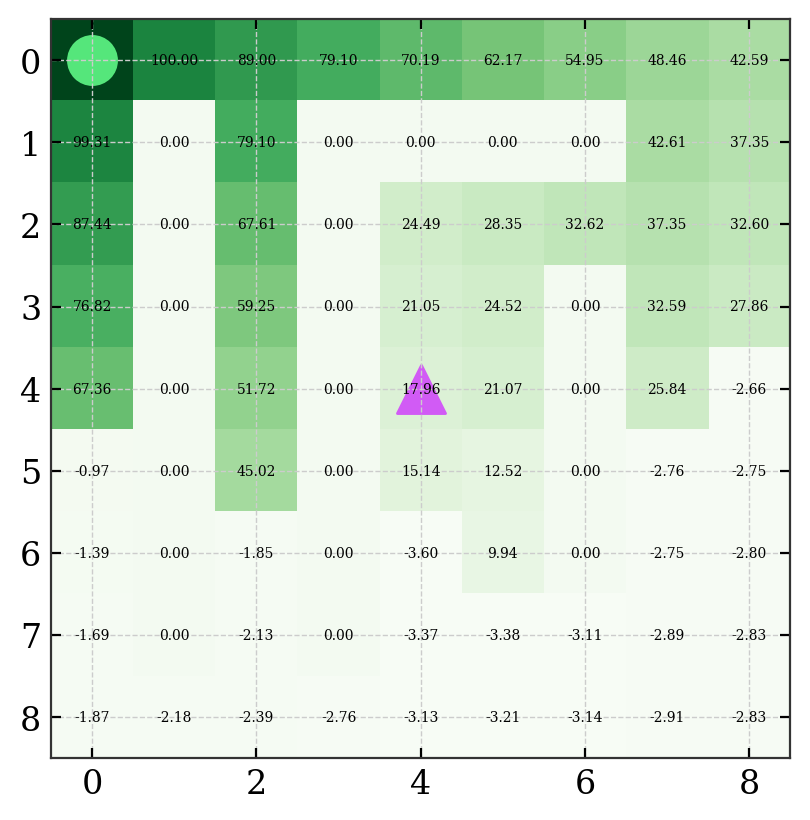

In [82]:
solution = np.max(agent.q_knowledge, axis=0)
solution[0,0] = 130
plt.imshow(solution, cmap='Greens', interpolation='nearest',)
for i in range(solution.shape[0]):
    for j in range(solution.shape[1]):
        if (i,j)==(0,0):
            continue
        plt.text(j, i, f"{solution[i, j]:.2f}", ha='center', va='center', color='black', fontsize=5)
plt.scatter(4, 4, marker='^', color='#d15bf5', s=300, label='Agent')
plt.scatter(0, 0, marker='o', color='#55e67b', s=300, label='Goal State')

In [63]:
np.max(solution)

129.30565447901077

In [ ]:
# format with 2 decimal places


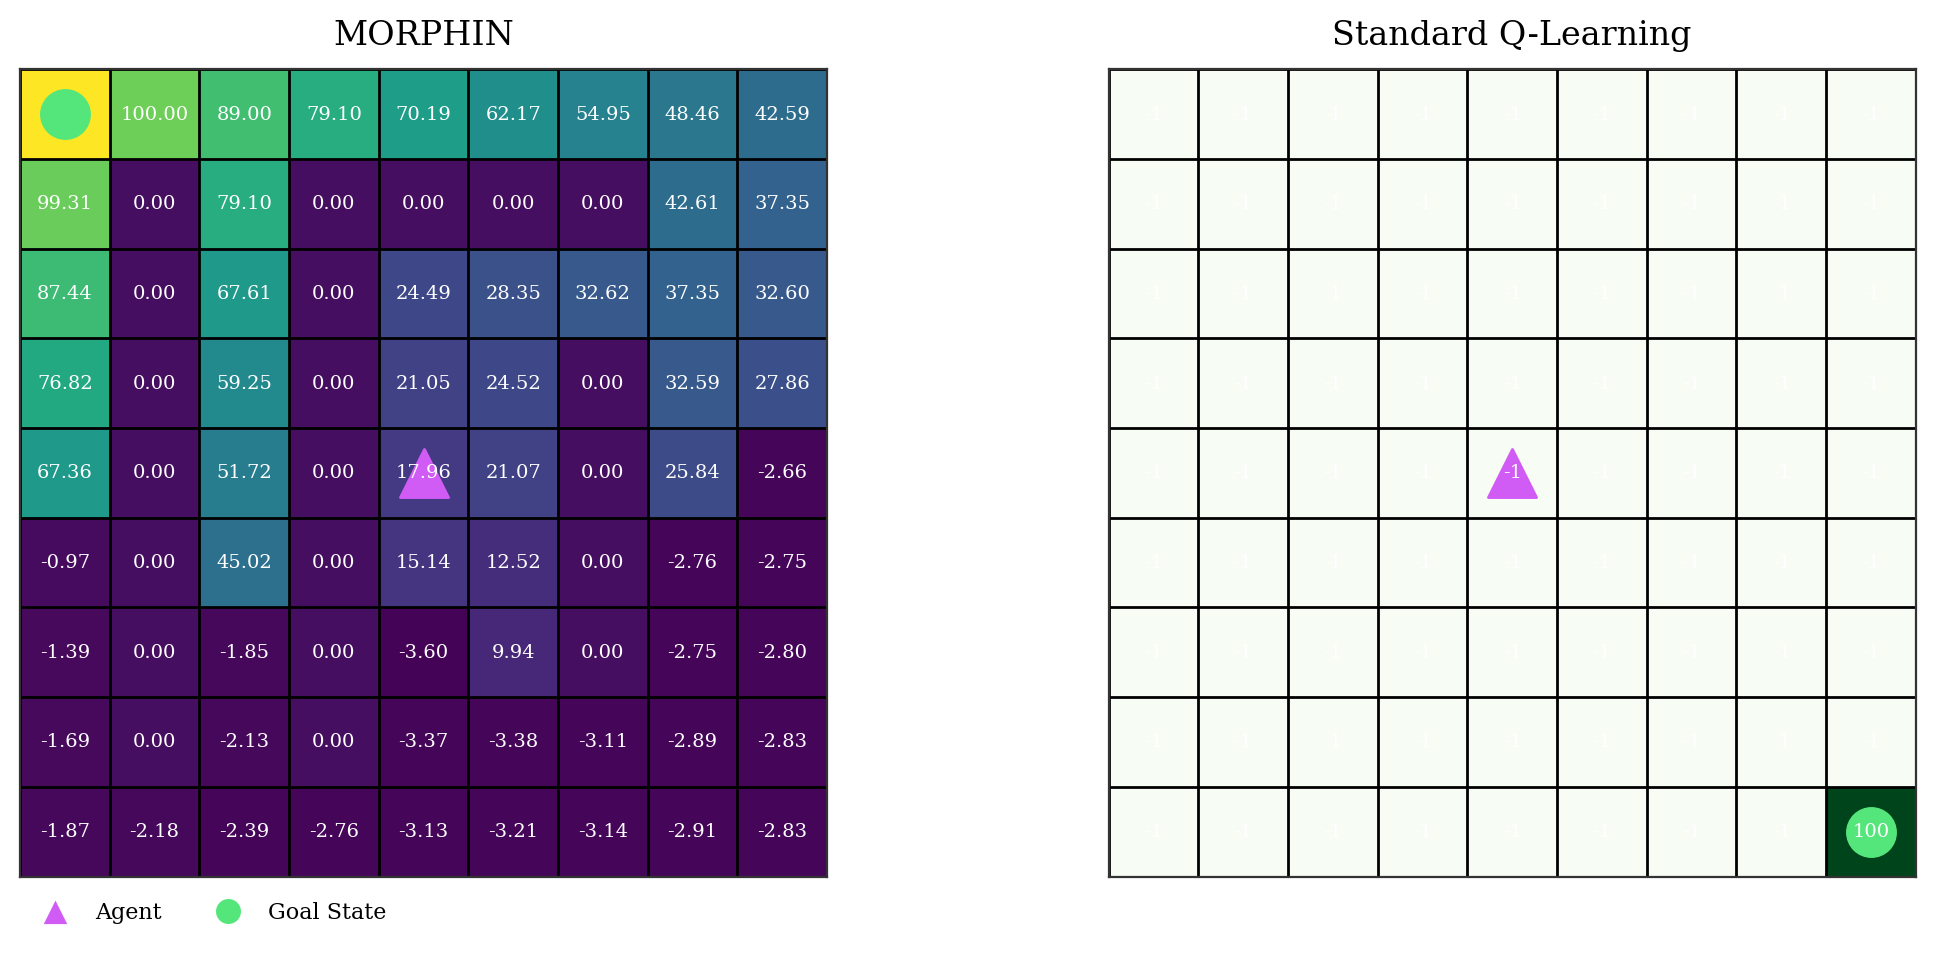

In [83]:
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

# Ejemplo de GRID_WORLD
N_ROWS, N_COLS = 9, 9
GRID_WORLD = np.zeros((N_ROWS, N_COLS)) - 1
GRID_WORLD[0, 0] = 100
GRID_WORLD[8, 8] = -1

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

solution = np.max(agent.q_knowledge, axis=0)
solution[0,0] = 130

# Primer subplot: configuración inicial
ax = axs[0]
im = ax.imshow(solution, cmap='viridis', interpolation='nearest', vmin=-5)
for i in range(solution.shape[0]):
    for j in range(solution.shape[1]):
        if (i,j)==(0,0):
            continue
        ax.text(j, i, f"{solution[i, j]:.2f}", ha='center', va='center', color='w', fontsize=7)
ax.scatter(4, 4, marker='^', color='#d15bf5', s=300, label='Agent')
ax.scatter(0, 0, marker='o', color='#55e67b', s=300, label='Goal State')
#ax.set_title("Inicio")
ax.set_xticks(np.arange(0, GRID_WORLD.shape[1], 1), minor=True)
ax.set_yticks(np.arange(0, GRID_WORLD.shape[0], 1), minor=True)
ax.set_xticks(np.arange(-0.5, GRID_WORLD.shape[1], 1), minor=False)
ax.set_yticks(np.arange(-0.5, GRID_WORLD.shape[0], 1), minor=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(which='major', color='black', linestyle='-', linewidth=1)
ax.tick_params(which='major', size=0)
ax.tick_params(which='minor', size=0)

# Segundo subplot: configuración modificada
GRID_WORLD[0, 0] = -1
GRID_WORLD[8, 8] = 100
ax2 = axs[1]
im2 = ax2.imshow(GRID_WORLD, cmap='Greens', interpolation='nearest')
for i in range(GRID_WORLD.shape[0]):
    for j in range(GRID_WORLD.shape[1]):
        ax2.text(j, i, str(int(GRID_WORLD[i, j])), ha='center', va='center', color='w', fontsize=7)
ax2.scatter(4, 4, marker='^', color='#d15bf5', s=300, label='Agent')
ax2.scatter(8, 8, marker='o', color='#55e67b', s=300, label='Goal State')
#ax2.set_title("Cambio de meta")
ax2.set_xticks(np.arange(0, GRID_WORLD.shape[1], 1), minor=True)
ax2.set_yticks(np.arange(0, GRID_WORLD.shape[0], 1), minor=True)
ax2.set_xticks(np.arange(-0.5, GRID_WORLD.shape[1], 1), minor=False)
ax2.set_yticks(np.arange(-0.5, GRID_WORLD.shape[0], 1), minor=False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.grid(which='major', color='black', linestyle='-', linewidth=1)
ax2.tick_params(which='major', size=0)
ax2.tick_params(which='minor', size=0)

# Add legend for the agent (triangle) and the goal (circle) with correct shapes and smaller symbols

agent_legend = Line2D([0], [0], marker='^', color='w', label='Agent',
                      markerfacecolor='#d15bf5', markersize=10, linestyle='None')
goal_legend = Line2D([0], [0], marker='o', color='w', label='Goal State',
                     markerfacecolor='#55e67b', markersize=10, linestyle='None')
ax.legend(handles=[agent_legend, goal_legend], loc='lower left', fontsize=8, frameon=False, ncol=2, bbox_to_anchor=(.005, -.07), borderaxespad=0.)

plt.subplots_adjust(wspace=10)

#plt.suptitle("Q-Value Heatmaps after 1,500 Episodes in a Non-Stationary Reward Environment", fontsize=16, y=1.01)
ax2.set_title("Standard Q-Learning", fontsize=12, y=1.01)
ax.set_title("MORPHIN", fontsize=12, y=1.01)

plt.tight_layout()

plt.savefig('q_table_comp_1.png', dpi=400, bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt

# Ejemplo de GRID_WORLD
N_ROWS, N_COLS = 9, 9
GRID_WORLD = np.zeros((N_ROWS, N_COLS)) - 1
GRID_WORLD[0, 0] = 100
GRID_WORLD[8, 8] = -1

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Primer subplot: configuración inicial
ax = axs[0]
im = ax.imshow(GRID_WORLD, cmap='Greens', interpolation='nearest')
for i in range(GRID_WORLD.shape[0]):
    for j in range(GRID_WORLD.shape[1]):
        ax.text(j, i, str(int(GRID_WORLD[i, j])), ha='center', va='center', color='black', fontsize=5)
ax.scatter(4, 4, marker='^', color='#d15bf5', s=300, label='Agent')
ax.scatter(0, 0, marker='o', color='#55e67b', s=300, label='Goal State')
#ax.set_title("Inicio")
ax.set_xticks(np.arange(0, GRID_WORLD.shape[1], 1), minor=True)
ax.set_yticks(np.arange(0, GRID_WORLD.shape[0], 1), minor=True)
ax.set_xticks(np.arange(-0.5, GRID_WORLD.shape[1], 1), minor=False)
ax.set_yticks(np.arange(-0.5, GRID_WORLD.shape[0], 1), minor=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(which='major', color='black', linestyle='-', linewidth=1)
ax.tick_params(which='major', size=0)
ax.tick_params(which='minor', size=0)

# Segundo subplot: configuración modificada
GRID_WORLD[0, 0] = -1
GRID_WORLD[8, 8] = 100
ax2 = axs[1]
im2 = ax2.imshow(GRID_WORLD, cmap='Greens', interpolation='nearest')
for i in range(GRID_WORLD.shape[0]):
    for j in range(GRID_WORLD.shape[1]):
        ax2.text(j, i, str(int(GRID_WORLD[i, j])), ha='center', va='center', color='black', fontsize=5)
ax2.scatter(4, 4, marker='^', color='#d15bf5', s=300, label='Agent')
ax2.scatter(8, 8, marker='o', color='#55e67b', s=300, label='Goal State')
#ax2.set_title("Cambio de meta")
ax2.set_xticks(np.arange(0, GRID_WORLD.shape[1], 1), minor=True)
ax2.set_yticks(np.arange(0, GRID_WORLD.shape[0], 1), minor=True)
ax2.set_xticks(np.arange(-0.5, GRID_WORLD.shape[1], 1), minor=False)
ax2.set_yticks(np.arange(-0.5, GRID_WORLD.shape[0], 1), minor=False)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.grid(which='major', color='black', linestyle='-', linewidth=1)
ax2.tick_params(which='major', size=0)
ax2.tick_params(which='minor', size=0)

# Add legend for the agent (triangle) and the goal (circle) with correct shapes and smaller symbols

agent_legend = Line2D([0], [0], marker='^', color='w', label='Agent',
                      markerfacecolor='#d15bf5', markersize=10, linestyle='None')
goal_legend = Line2D([0], [0], marker='o', color='w', label='Goal State',
                     markerfacecolor='#55e67b', markersize=10, linestyle='None')
ax.legend(handles=[agent_legend, goal_legend], loc='lower left', fontsize=8, frameon=False, ncol=2, bbox_to_anchor=(.005, -.07), borderaxespad=0.)

plt.subplots_adjust(wspace=10)

plt.suptitle("Concept Drift: Reward Relocation", fontsize=16, y=.95)

plt.tight_layout()

plt.savefig('rewards_change.png', dpi=400, bbox_inches='tight')
plt.show()


In [100]:
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1000)

In [101]:
ani.save("../simulations/memory_stm_v5.mp4")

### Multiple repetitions

In [48]:
convergence_simulations = []
total_steps = []


for _ in tqdm(range(1000)):
    # Inicialización del entorno y parámetros
    N_ROWS = 9
    N_COLS = 9
    GRID_WORLD = np.zeros((N_ROWS, N_COLS)) - 1

    # Definición de los estados meta
    GOAL_STATE_1 = (0, 0)
    GOAL_STATE_2 = (8, 8)
    GRID_WORLD[GOAL_STATE_1] = 100  # Objetivo inicial
    GRID_WORLD[GOAL_STATE_2] = -1  # Penalización inicial

    EXPLOTATION = 0.2

    # Inicialización del agente
    agent = AdaptativeAgent(
        initial_state=(4, 4),
        actions=['Up', 'Down', 'Left', 'Right'],
        n_rows=N_ROWS,
        n_cols=N_COLS,
        decay_rate=0.05,
        alpha=0.1,
        alpha_max=0.99,
        td_threshold=5,
    )

    # Inicialización del Page-Hinkley Test
    ph_test = PageHinkley(delta=0.5, threshold=300.0)

    # Variables para el seguimiento del entrenamiento
    learning_curve = []
    exploration_curve = []
    step_changes = []
    episode_to_step = {}
    alpha_evol = []
    episode = 0
    ite = 0  # Contador total de iteraciones
    e = 0     # Contador para la función de decaimiento de epsilon

    first_qtable = agent.q_knowledge.copy()
    stage_block = [0, 300, 600, 900, 1200 ,1500, 1600]
    converged_episodes = []
    converged_i = 0

    # Variable para la recompensa acumulada del episodio
    episode_reward = 0.0

    # Para este ejemplo, modificaremos el entorno en episodios específicos
    episode_changes = [300, 600, 900, 1200]

    q_learning_acc = 0.0

    outlier_reward = None

    # Bucle de entrenamiento
    while episode < 1500:
        # Selecciona la acción usando epsilon adaptativo
        adaptive_epsilon = agent.epsilon_decay(step=e)
        action = agent.choose_action(adaptive_epsilon)
        
        initial_state = agent.current_state
        next_state = agent.get_next_state(initial_state, action)
        reward = GRID_WORLD[next_state]
        
        # Acumula la recompensa del episodio
        episode_reward += reward

        # Realiza el movimiento y actualiza la Q-table
        new_q = agent.move(reward, action)
        q_learning_acc += new_q

        # Actualiza métricas (por ejemplo, para visualización)
        exploration_curve.append([adaptive_epsilon, new_q])
        alpha_evol.append(agent.effective_alpha)
        
        ite += 1

        # Finaliza el episodio si se alcanza un objetivo o se excede un límite de pasos
        if (GRID_WORLD[next_state]==100) or (agent.steps > (N_COLS + N_ROWS) * 2):
            
            e += 1
            
            if outlier_reward and outlier_reward-episode_reward >= outlier_reward:
                e *= 0.6
            elif outlier_reward and outlier_reward-episode_reward < outlier_reward:
                e *= 15

            episode += 1
            
            # Registra la recompensa media del episodio (puedes ajustar la métrica que prefieras)
            learning_curve.append(q_learning_acc / ite)
            
            if ph_test.update(episode_reward):
                outlier_reward = episode_reward
                e = 0
                ph_test.reset()
            
            # (Opcional) Si en episodios específicos se desea cambiar el entorno:
            if episode in episode_changes:
                # Alterna el objetivo cambiando la recompensa en el grid
                if episode in [300, 900, 1500]:
                    GRID_WORLD[GOAL_STATE_1] = -1
                    GRID_WORLD[GOAL_STATE_2] = 100
                else:
                    GRID_WORLD[GOAL_STATE_1] = 100
                    GRID_WORLD[GOAL_STATE_2] = -1
                step_changes.append(ite)
                episode_to_step[episode] = ite 
            
            # Identify if the agent already converged
            if episode > 1:
                # Use stage_block to determine current stage boundaries
                if converged_i < len(stage_block) - 1:
                    prev_change = stage_block[converged_i]
                    next_change = stage_block[converged_i + 1]
                else:
                    prev_change = stage_block[-2]
                    next_change = stage_block[-1]
                # Check if Q-table has converged before the next environment change
                if (np.max(np.abs(agent.q_knowledge - first_qtable)) < 0.01) and (prev_change < episode < next_change):
                    converged_episodes.append(episode)
                    converged_i += 1
                else:
                    first_qtable = agent.q_knowledge.copy()
            
            # Reinicia el agente y la recompensa acumulada para el siguiente episodio
            agent.restart()
            episode_reward = 0.0
            
    convergence_simulations.append(converged_episodes)
    total_steps.append(len(exploration_curve))

100%|██████████| 1000/1000 [05:00<00:00,  3.33it/s]


In [53]:
np.mean(total_steps), np.std(total_steps)
# calculate the incertidumbre of the total_steps in porcentage
mean_steps = np.mean(total_steps)
std_steps = np.std(total_steps)
incert = (std_steps / mean_steps) * 100
print(f"Mean total steps: {mean_steps:.2f} ± {std_steps:.2f} ({incert:.2f}%)")

Mean total steps: 23292.07 ± 1474.13 (6.33%)


In [55]:
for ix in range(5):
    mean_convergence = np.mean([i[ix] for i in convergence_simulations if len(i)==5])
    std_convergence = np.std([i[ix] for i in convergence_simulations if len(i)==5])
    incert_convergence = (std_convergence / mean_convergence) * 100
    print(f"Mean convergence ({ix+1} change): {mean_convergence:.2f} ± {std_convergence:.2f} ({incert_convergence:.2f}%)")

Mean convergence (1 change): 135.81 ± 12.64 (9.31%)
Mean convergence (2 change): 475.17 ± 27.54 (5.80%)
Mean convergence (3 change): 767.81 ± 24.05 (3.13%)
Mean convergence (4 change): 1069.74 ± 26.25 (2.45%)
Mean convergence (5 change): 1367.19 ± 25.16 (1.84%)


In [51]:
sum(True if len(i) == 5 else False for i in convergence_simulations), len(convergence_simulations)

(999, 1000)

In [56]:
# if trad q learning takes 256.40 ± 11.15 (4.35%)  to converge, and adaptive 135.81 ± 12.64 (9.31%), calculate how much the adaptive is faster
trad_mean = 256.40
trad_std = 11.15
trad_inc = 4.35
adapt_mean = 135.81
adapt_std = 12.64
adapt_inc = 9.31
trad_inc = (trad_std / trad_mean) * 100
adapt_inc = (adapt_std / adapt_mean) * 100
adapt_speed = (trad_mean / adapt_mean) * 100
print(f"Adaptive is {adapt_speed:.2f}% faster than traditional Q-learning")

Adaptive is 188.79% faster than traditional Q-learning


In [57]:
40683.74/23292.07 * 100

174.6677731949114

In [ ]:
sum(True if len(i) == 5 else False for i in convergence_simulations), len(convergence_simulations)

(999, 1000)